In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Dense,Flatten,Lambda,Input,Conv2D

In [4]:
from tensorflow.keras.layers import Activation,ZeroPadding2D,add,MaxPooling2D,BatchNormalization

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [38]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix

In [7]:
IMAGE_SIZE=[224,224]
epochs=7
batch_size=128

In [8]:
from glob import glob

In [16]:
train_path='TRAIN'
valid_path='TEST'

image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [17]:
folders = glob(train_path + '/*')

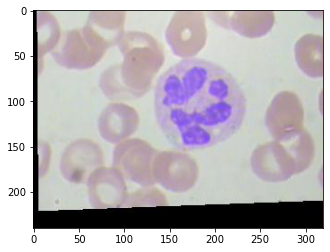

In [18]:
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [19]:
def identity_block(input_,filters,kernel_size):
  f1,f2,f3=filters
  x=Conv2D(f1,(1,1))(input_)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  x=Conv2D(f2,kernel_size,padding='same')(x)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  x=Conv2D(f3,(1,1))(x)
  x=BatchNormalization()(x)

  x=add([x,input_])
  x=Activation('relu')(x)
  return x


In [20]:
def conv_block(input_,filters,kernel_size,strides=(2,2)):
  f1,f2,f3=filters
  x=Conv2D(f1,(1,1),strides=strides)(input_)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)
  
  x=Conv2D(f2,kernel_size,padding='same')(x)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  x=Conv2D(f3,(1,1))(x)
  x=BatchNormalization()(x)

  shortcut=Conv2D(f3,(1,1),strides=strides)(input_)
  shortcut=BatchNormalization()(shortcut)

  x=add([x,shortcut])
  x=Activation('relu')(x)
  return x

In [21]:
i=Input(shape=IMAGE_SIZE+[3])
x=ZeroPadding2D(padding=(3,3))(i)
x=Conv2D(64,(7,7),padding='valid',strides=(2,2))(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=ZeroPadding2D(padding=(1,1))(x)
x=MaxPooling2D((3, 3), strides=(2, 2))(x)

x=conv_block(x,[64,64,256],3,strides=(1,1))
x=identity_block(x,[64,64,256],3)
x=identity_block(x,[64,64,256],3)

x=conv_block(x,[256,256,512],3)
x=identity_block(x,[256,256,512],3)
x=identity_block(x,[256,256,512],3)
x=identity_block(x,[256,256,512],3)

x=Flatten()(x)
prediction=Dense(len(folders),activation='softmax')(x)
model=Model(inputs=i,outputs=prediction)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

In [23]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [24]:
def preprocess_input2(x):
  x=x/127.5
  x=x-1
  return x

train_gen=ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input2
)

valid_gen=ImageDataGenerator(preprocessing_function=preprocess_input2)
     

In [25]:
testgen=valid_gen.flow_from_directory(directory=valid_path,target_size=IMAGE_SIZE)
print(testgen.class_indices)

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


In [26]:
labels=[None]*len(folders)

for k,v in testgen.class_indices.items():
  labels[v]=k     

In [27]:
labels

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -1.0 max: 1.0
[0. 1. 0. 0.]


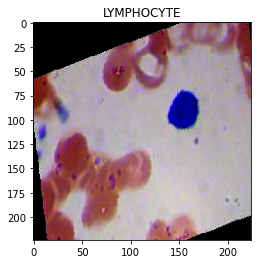

In [28]:
for x,y in testgen:
  print("min:", x[0].min(), "max:", x[0].max())
  print(y[0])
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [29]:
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse'
)

valid_generator=valid_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse'
)
     

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [31]:
checkpoint_filepath = './tmp/checkpoint'
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
  callbacks=[
    tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
  ]
)

Epoch 1/7
77/77 [==============================] - 2445s 32s/step - loss: 2.1499 - accuracy: 0.4324 - val_loss: 5.6222 - val_accuracy: 0.2500
Epoch 2/7
77/77 [==============================] - 2505s 33s/step - loss: 1.0219 - accuracy: 0.6351 - val_loss: 5.1377 - val_accuracy: 0.2496
Epoch 3/7
77/77 [==============================] - 2534s 33s/step - loss: 0.4876 - accuracy: 0.8165 - val_loss: 6.7485 - val_accuracy: 0.2492
Epoch 4/7
77/77 [==============================] - 2515s 33s/step - loss: 0.3330 - accuracy: 0.8755 - val_loss: 9.1552 - val_accuracy: 0.2664
Epoch 5/7
77/77 [==============================] - 2495s 32s/step - loss: 0.2627 - accuracy: 0.9054 - val_loss: 3.0116 - val_accuracy: 0.5584
Epoch 6/7
77/77 [==============================] - 2502s 32s/step - loss: 0.2068 - accuracy: 0.9248 - val_loss: 2.0039 - val_accuracy: 0.7002
Epoch 7/7
77/77 [==============================] - 2485s 32s/step - loss: 0.2197 - accuracy: 0.9216 - val_loss: 0.7992 - val_accuracy: 0.7743


In [39]:
def get_confusion_matrix(data_path, N):
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in valid_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm
     

In [40]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
[[341 186   0  96]
 [  0 617   3   0]
 [ 60  22 531   7]
 [ 61 110  15 438]]


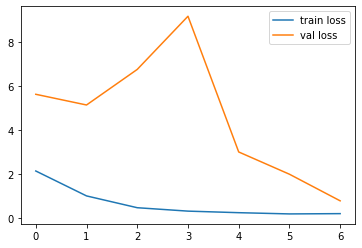

In [41]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

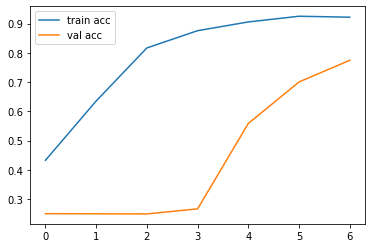

In [42]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
